# Granger Causality Analysis for Infant EEG Data

This notebook performs Granger causality analysis on infant EEG data to identify causal relationships between different brain regions. Granger causality measures whether one time series can predict another time series better than the series can predict itself.

## Analysis Steps:
1. **Data Loading and Preprocessing**
   - Load EEG data from .edf files
   - Filter signals (0.5-30 Hz bandpass)
   - Extract standard EEG channels
   - Downsample for computational efficiency

2. **Granger Causality Computation**
   - Calculate GC for all channel pairs
   - Optimize lag parameters (max_lag=2-10)
   - Apply significance testing (p < 0.05)
   - Generate connectivity matrices

3. **Visualization and Network Analysis**
   - Plot connectivity heatmaps
   - Create network graphs with thresholding
   - Analyze node degree statistics
   - Map brain region interactions

4. **Temporal Dynamics Analysis**
   - Segment data into time windows
   - Track connectivity evolution over time
   - Assess connection stability/consistency
   - Compare different window sizes

5. **Statistical Analysis and Interpretation**
   - Identify strongest connections
   - Analyze brain region connectivity patterns
   - Generate summary statistics
   - Export results for further analysis

6. **Results Export and Documentation**
   - Save connectivity matrices and statistics
   - Generate publication-ready plots
   - Create analysis summary reports

In [ ]:
# EEG Granger Causality Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import os
import re
import warnings
from scipy import signal
from statsmodels.tsa.stattools import grangercausalitytests
import networkx as nx
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp

# Clean output
warnings.filterwarnings('ignore')
mne.set_log_level('WARNING')

# Better plots
plt.rcParams['figure.dpi'] = 100
sns.set_palette("husl")

# Reproducible results
np.random.seed(42)

# CPU core detection
N_CORES = mp.cpu_count()
print(f"Detected {N_CORES} CPU cores - using all for parallel processing")
print("Ready to analyze brain connectivity!")

Detected 16 CPU cores - using all for parallel processing
Ready to analyze brain connectivity!


## 1. Data Loading and Preprocessing

In [75]:
def load_eeg_data(file_path):
    """Load EEG data and show basic info"""
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    
    print(f"Loaded EEG data: {len(raw.ch_names)} channels, {raw.times[-1]:.1f}s duration")
    print(f"Channels: {raw.ch_names}")
    
    return raw

# Load the data
data_path = './Dataset/Infants_data/sub-NORB00005_ses-1_task-EEG_eeg.edf'
raw = load_eeg_data(data_path)

Loaded EEG data: 19 channels, 776.0s duration
Channels: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


In [76]:
def setup_output_folder(file_path):
    """Create output folder based on filename"""
    # Get filename without extension
    filename = os.path.basename(file_path).replace('.edf', '')
    
    # Create output directory
    output_dir = f'./Dataset/Infants_data_output/{filename}'
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Output folder: {output_dir}")
    return output_dir

# Setup output directory
output_dir = setup_output_folder(data_path)

Output folder: ./Dataset/Infants_data_output/sub-NORB00005_ses-1_task-EEG_eeg


In [77]:
def preprocess_eeg(raw, lowpass=30, highpass=0.5):
    """Clean and filter EEG data"""
    # Filter the data
    raw_filtered = raw.copy()
    raw_filtered.filter(highpass, lowpass, fir_design='firwin', verbose=False)
    
    # Get data and extract EEG channels only
    data, times = raw_filtered[:, :]
    
    # Standard EEG electrodes
    eeg_names = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'FZ', 'C3', 'C4', 'CZ', 
                 'P3', 'P4', 'PZ', 'O1', 'O2', 'T3', 'T4', 'T5', 'T6']
    
    # Find EEG channels
    eeg_indices = []
    eeg_channels = []
    
    for i, ch in enumerate(raw_filtered.ch_names):
        if ch in eeg_names:
            eeg_indices.append(i)
            eeg_channels.append(ch)
    
    # Extract clean EEG data
    clean_data = data[eeg_indices, :]
    
    print(f"Preprocessed: {len(eeg_channels)} EEG channels")
    print(f"Channels: {eeg_channels}")
    print(f"Data shape: {clean_data.shape}")
    
    return clean_data, eeg_channels, times

# Preprocess the data
eeg_data, channel_names, times = preprocess_eeg(raw)
sampling_freq = raw.info['sfreq']

Preprocessed: 19 EEG channels
Channels: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']
Data shape: (19, 155200)


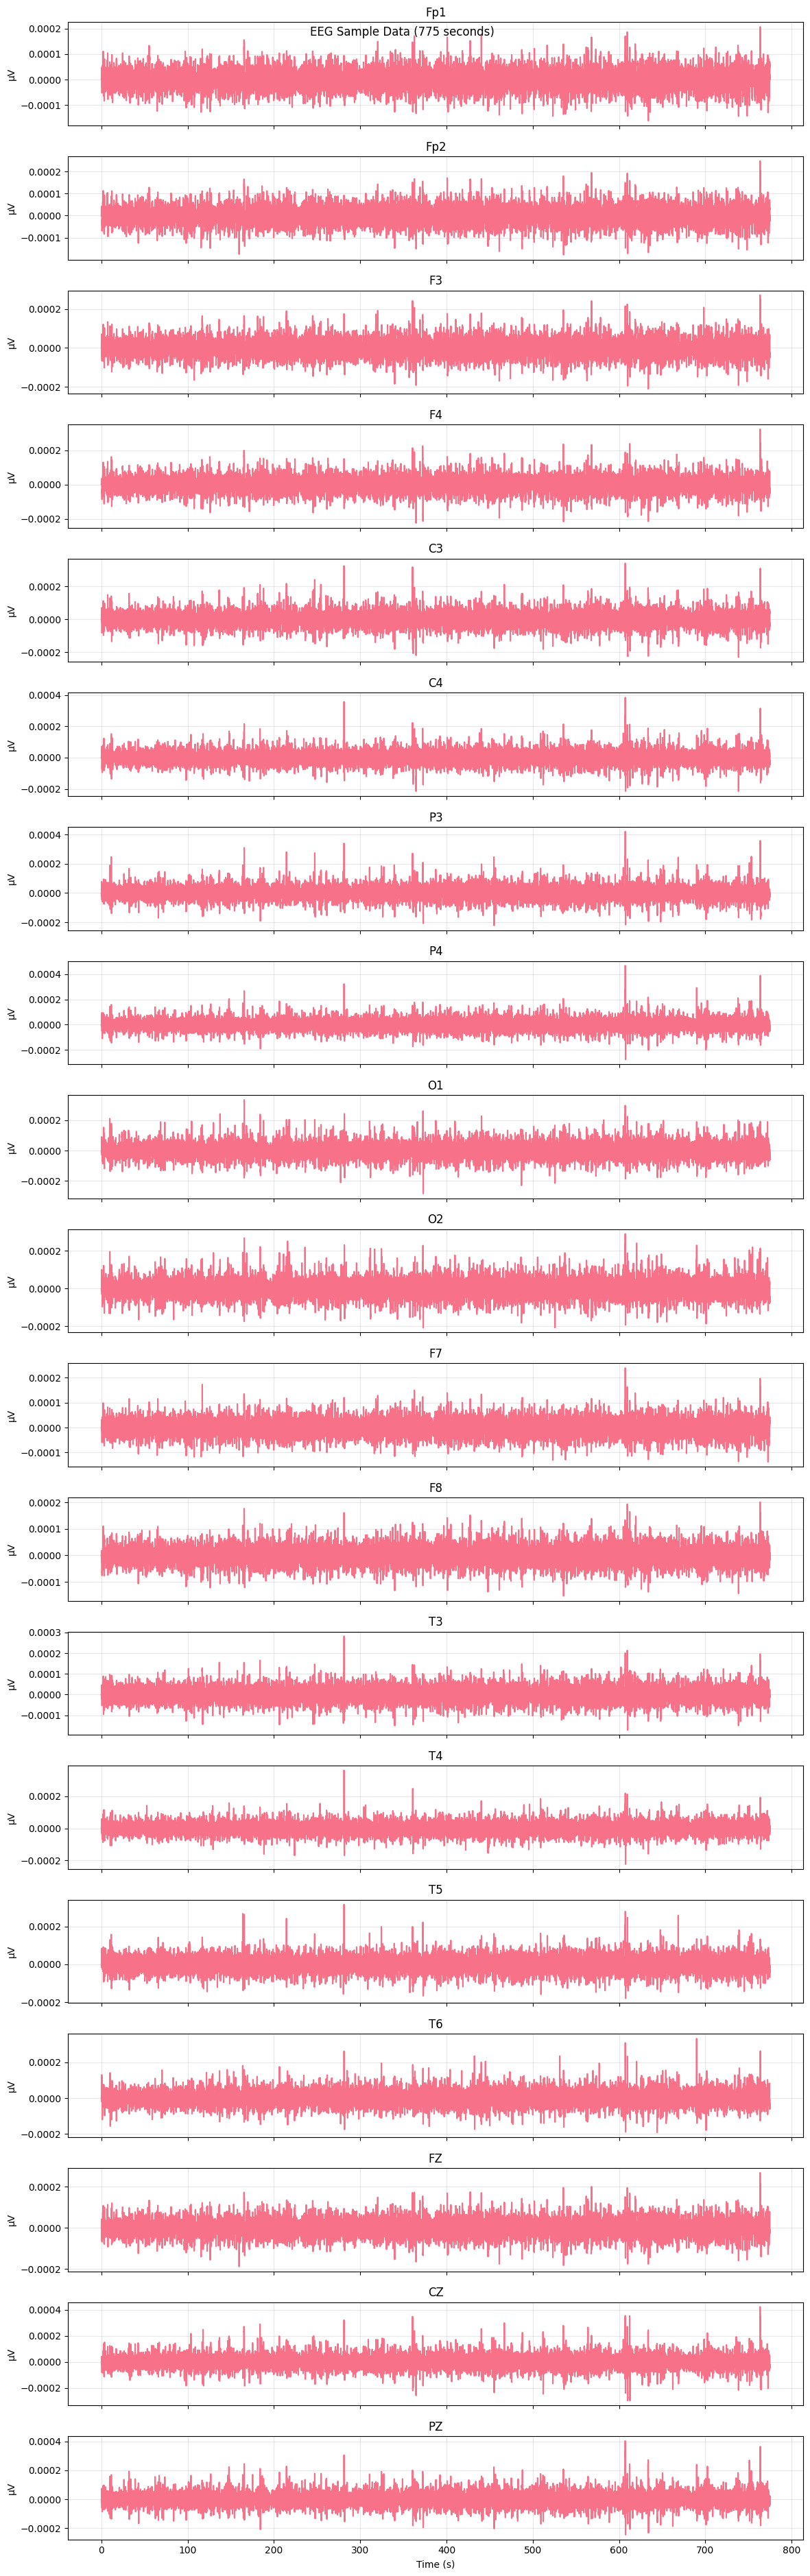

In [78]:
# Visualize sample EEG data
def plot_eeg_sample(data, channels, times, duration=10, save_path=None):
    """Plot first 4 EEG channels for quick visualization"""
    # Calculate time window
    samples = int(duration * sampling_freq)
    time_slice = slice(0, min(samples, data.shape[1]))

    n_channels = len(channels)
    
    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2 * n_channels), sharex=True)
    
    for i in range(n_channels):
        if i < len(channels):
            axes[i].plot(times[time_slice], data[i, time_slice])
            axes[i].set_title(f'{channels[i]}')
            axes[i].set_ylabel('µV')
            axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time (s)')
    plt.suptitle(f'EEG Sample Data ({duration} seconds)')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot sample data
plot_eeg_sample(
    eeg_data, channel_names, times, 
    duration= int(raw.times[-1]),
    save_path=os.path.join(output_dir, 'eeg_sample_data.png')
)

## 2. Granger Causality Analysis Functions

In [79]:
def prepare_data(data, original_fs, target_fs=100, max_duration=320):
    """Downsample and trim data for faster computation"""
    # Ensure input is numpy array
    data = np.asarray(data)
    
    # Skip downsampling if not needed
    if original_fs <= target_fs:
        processed_data = data.copy()
        new_fs = original_fs
    else:
        # Downsample using scipy
        from scipy import signal
        n_new = int(data.shape[1] * target_fs / original_fs)
        processed_data = np.asarray(signal.resample(data, n_new, axis=1))
        new_fs = target_fs
        print(f"Downsampled: {original_fs} → {new_fs} Hz")
    
    # Trim to max duration
    max_samples = int(max_duration * new_fs)
    if processed_data.shape[1] > max_samples:
        processed_data = processed_data[:, :max_samples]
        print(f"Using first {max_duration}s: {processed_data.shape}")
    else:
        print(f"Using all data: {processed_data.shape}")
    
    return processed_data, new_fs

# Process the data
eeg_subset, new_fs = prepare_data(eeg_data, sampling_freq, target_fs=100, max_duration= int(raw.times[-1])) # We can change max_duration here

Downsampled: 200.0 → 100 Hz
Using first 775s: (19, 77500)


In [80]:
def calculate_granger_causality_pair(args):
    """Helper function for parallel GC computation"""
    i, j, data, channel_names, max_lag = args
    try:
        test_data = np.column_stack([data[j, :], data[i, :]])
        result = grangercausalitytests(test_data, max_lag, verbose=False)
        best_result = min(
            (result[lag][0]['ssr_ftest'] for lag in range(1, max_lag + 1)),
            key=lambda x: x[1]
        )
        return i, j, best_result[0], best_result[1]
    except Exception as e:
        return i, j, 0.0, 1.0

def calculate_granger_causality(data, channel_names, max_lag=10, alpha=0.05):
    """Calculate Granger causality between all channel pairs"""
    n_channels = len(channel_names)
    gc_matrix = np.zeros((n_channels, n_channels))
    p_values = np.ones((n_channels, n_channels))
    
    
    # Create pairs for parallel processing
    pairs = [(i, j, data, channel_names, max_lag) 
             for i in range(n_channels) for j in range(n_channels) if i != j]
    
    # Process in parallel
    with ProcessPoolExecutor(max_workers=N_CORES) as executor:
        results = list(executor.map(calculate_granger_causality_pair, pairs))
    
    # Fill matrices
    for i, j, f_stat, p_val in results:
        gc_matrix[i, j] = f_stat
        p_values[i, j] = p_val
    
    return gc_matrix, p_values

def apply_significance_threshold(gc_matrix, p_values, alpha=0.05):
    """Apply significance threshold to GC matrix"""
    return np.where(p_values <= alpha, gc_matrix, 0)

In [81]:
print("Calculating Granger Causality...")

gc_matrix, p_values = calculate_granger_causality(eeg_subset, channel_names, max_lag=2)
significant_gc = apply_significance_threshold(gc_matrix, p_values)

n_sig, n_total = np.sum(significant_gc > 0), len(channel_names) * (len(channel_names) - 1)
print(f"Found {n_sig}/{n_total} significant connections ({n_sig/n_total*100:.1f}%) in full time length")

Calculating Granger Causality...
Found 341/342 significant connections (99.7%) in full time length
Found 341/342 significant connections (99.7%) in full time length


## 3. Visualization of Results

Plotting connectivity matrices...


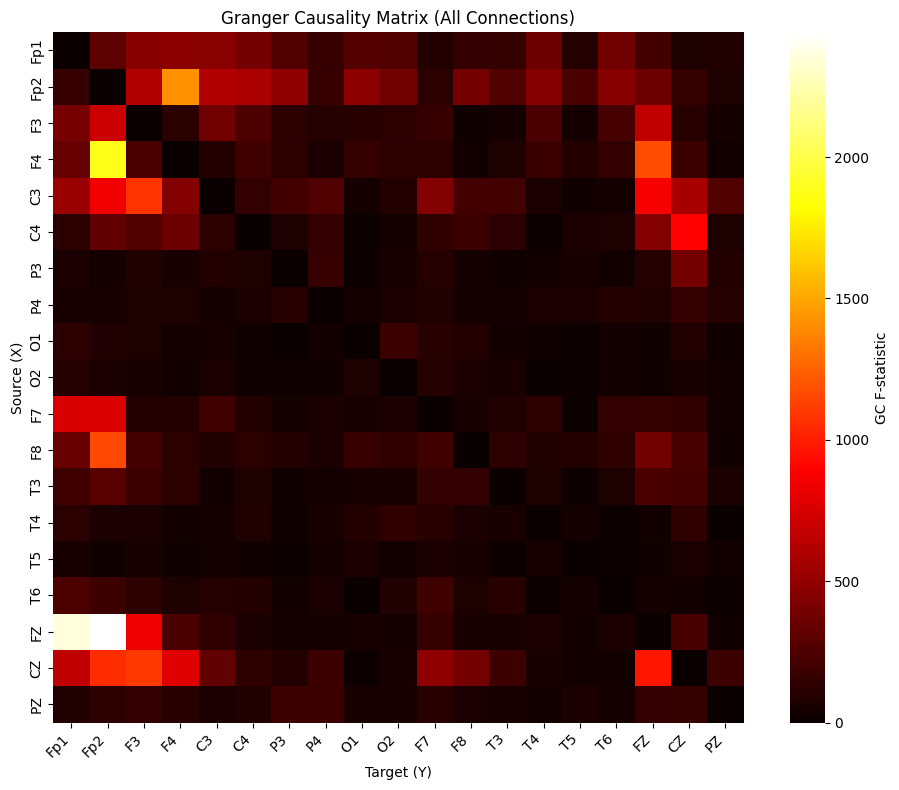

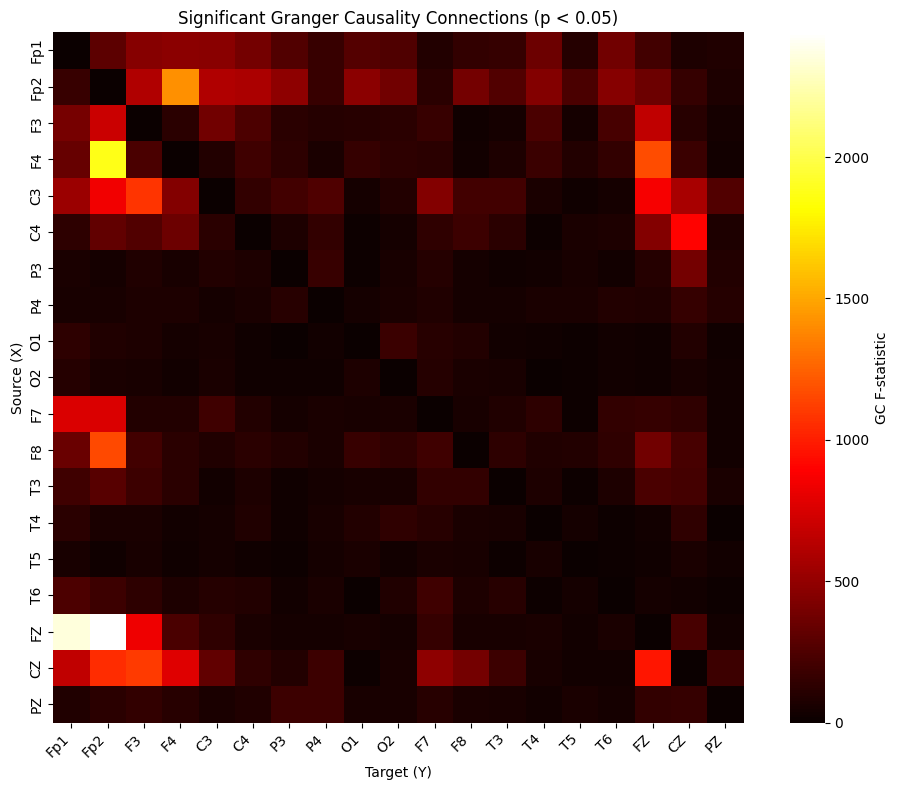

In [82]:
def plot_connectivity_matrix(matrix, channel_names, title, cmap='hot', save_path=None):
    """Plot connectivity matrix as heatmap"""
    plt.figure(figsize=(10, 8))
    
    # Create heatmap with seaborn (simpler and prettier)
    sns.heatmap(matrix, 
                xticklabels=channel_names, 
                yticklabels=channel_names,
                cmap=cmap, 
                cbar_kws={'label': 'GC F-statistic'},
                square=True)
    
    plt.title(title)
    plt.xlabel('Target (Y)')
    plt.ylabel('Source (X)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot both matrices
print("Plotting connectivity matrices...")

plot_connectivity_matrix(
    gc_matrix, channel_names, 
    'Granger Causality Matrix (All Connections)',
    save_path=os.path.join(output_dir, 'gc_matrix_all_connections.png')
)

plot_connectivity_matrix(
    significant_gc, channel_names,
    'Significant Granger Causality Connections (p < 0.05)',
    save_path=os.path.join(output_dir, 'gc_matrix_significant_connections.png')
)

Network: 19 nodes, 18 edges


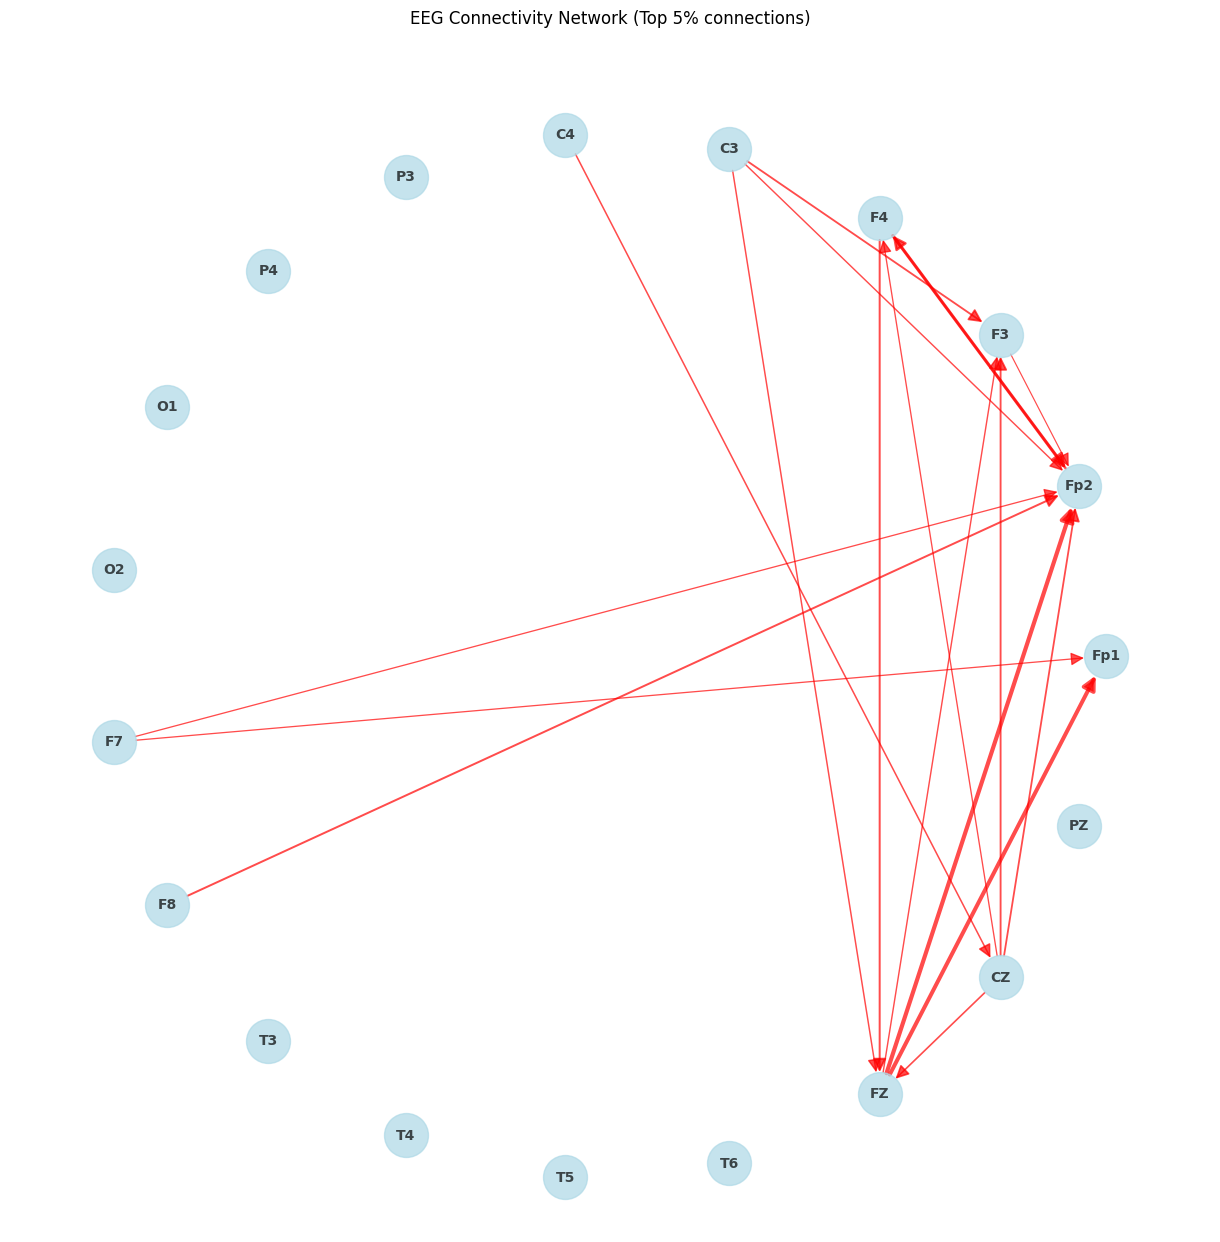

In [83]:
def plot_connectivity_network(gc_matrix, channel_names, threshold_percentile=80, save_path=None):
    """Plot connectivity as a network graph"""
    # Check if there are any non-zero values to calculate percentile
    non_zero_values = gc_matrix[gc_matrix > 0]
    if len(non_zero_values) == 0:
        print("No connections found in the matrix")
        return None
    
    # Apply threshold and create graph
    threshold = np.percentile(non_zero_values, threshold_percentile)
    thresholded_matrix = np.where(gc_matrix >= threshold, gc_matrix, 0)
    G = nx.from_numpy_array(thresholded_matrix, create_using=nx.DiGraph)
    
    # Create proper node mapping dictionary
    node_mapping = {}
    for i, name in enumerate(channel_names):
        node_mapping[i] = name
    
    # Relabel nodes with channel names
    G = nx.relabel_nodes(G, node_mapping)
    
    # Check if graph has edges
    if G.number_of_edges() == 0:
        print(f"No edges found with threshold percentile {threshold_percentile}")
        print(f"Try lowering the threshold_percentile (current: {threshold_percentile})")
        return G
    
    # Plot
    plt.figure(figsize=(12, 12))
    pos = nx.circular_layout(G)
    
    # Calculate edge widths safely
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [weight / max_weight * 3 for weight in edge_weights]
    
    # Draw network
    nx.draw(G, pos, 
            node_color='lightblue', 
            node_size=1000,
            with_labels=True,
            font_size=10,
            font_weight='bold',
            edge_color='red',
            arrows=True,
            arrowsize=20,
            width=edge_widths,
            alpha=0.7)
    
    plt.title(f'EEG Connectivity Network (Top {100-threshold_percentile}% connections)')
    plt.axis('off')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(f"Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

# Plot network
G = plot_connectivity_network(
    significant_gc, channel_names, 
    threshold_percentile=95,
    save_path=os.path.join(output_dir, 'connectivity_network.png')
)
plt.show()

## 4. Statistical Analysis and Summary

CONNECTIVITY SUMMARY
Significant: 341/342 (99.7%)

TOP CONNECTED CHANNELS
Channel  Out  In  Total
    Fp1   18  18     36
    Fp2   18  18     36
     F3   18  18     36
     F4   18  18     36
     C3   18  18     36
     C4   18  18     36
     P3   18  18     36
     P4   18  18     36
     O1   18  18     36
     O2   18  18     36

TOP 10 STRONGEST CONNECTIONS
Source Target      F-stat  p-value
    FZ    Fp2 2441.272277      0.0
    FZ    Fp1 2349.738567      0.0
    F4    Fp2 1871.979374      0.0
   Fp2     F4 1420.319948      0.0
    F4     FZ 1171.669112      0.0
    F8    Fp2 1161.420083      0.0
    CZ     F3 1103.003733      0.0
    C3     F3 1081.247446      0.0
    CZ    Fp2 1051.462430      0.0
    CZ     FZ  971.850540      0.0


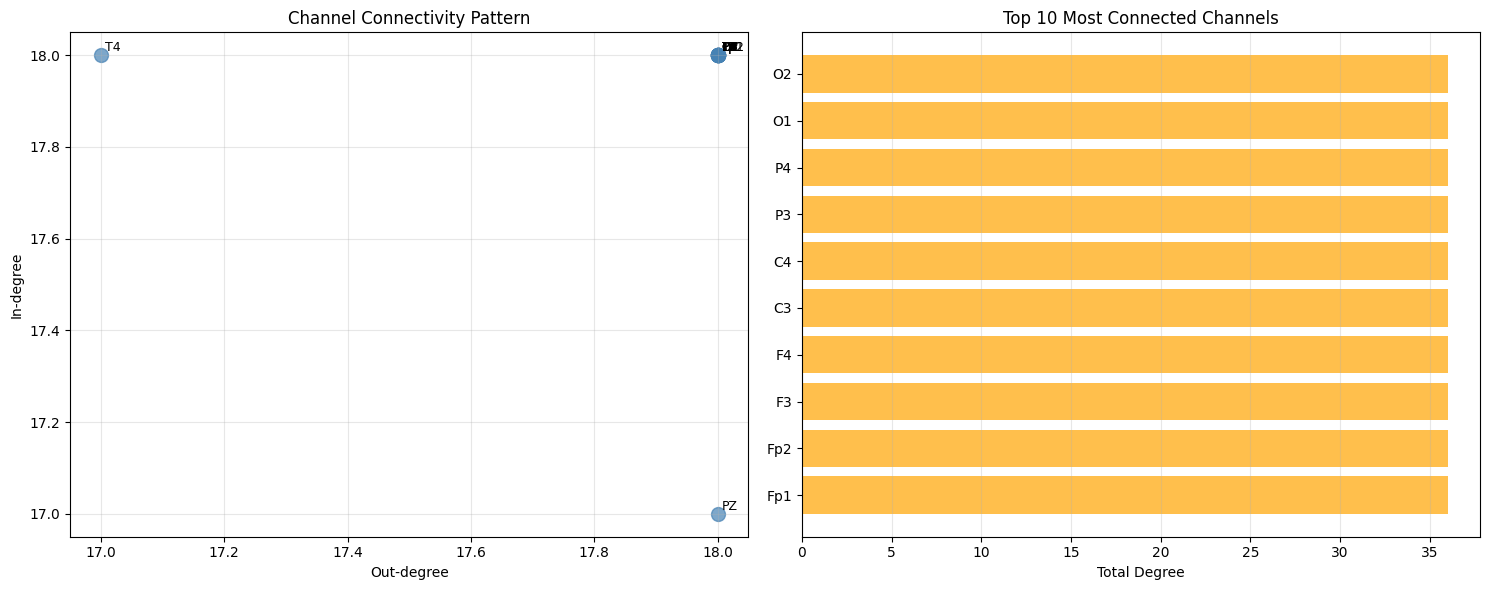

In [84]:
def analyze_connectivity_statistics(gc_matrix, p_values, channel_names, alpha=0.05, save_dir=None):
    """Analyze connectivity statistics and create visualizations"""
    
    # Calculate basic stats
    significant_mask = p_values < alpha
    n_total = len(channel_names) * (len(channel_names) - 1)
    n_significant = np.sum(significant_mask)
    
    print(f"CONNECTIVITY SUMMARY")
    print(f"Significant: {n_significant}/{n_total} ({n_significant/n_total*100:.1f}%)")
    
    # Node statistics
    out_degree = np.sum(significant_mask, axis=1)
    in_degree = np.sum(significant_mask, axis=0)
    
    node_stats = pd.DataFrame({
        'Channel': channel_names,
        'Out': out_degree,
        'In': in_degree,
        'Total': out_degree + in_degree
    }).sort_values('Total', ascending=False)
    
    print(f"\nTOP CONNECTED CHANNELS")
    print(node_stats.head(10).to_string(index=False))
    
    # Top connections
    connections_df = None
    if n_significant > 0:
        # Vectorized approach for finding significant connections
        sig_i, sig_j = np.where(significant_mask)
        connections_df = pd.DataFrame({
            'Source': [channel_names[i] for i in sig_i],
            'Target': [channel_names[j] for j in sig_j],
            'F-stat': gc_matrix[sig_i, sig_j],
            'p-value': p_values[sig_i, sig_j]
        }).sort_values('F-stat', ascending=False)
        
        print(f"\nTOP 10 STRONGEST CONNECTIONS")
        print(connections_df.head(10).to_string(index=False))
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot
    ax1.scatter(node_stats['Out'], node_stats['In'], s=100, alpha=0.7, color='steelblue')
    for _, row in node_stats.iterrows():
        ax1.annotate(row['Channel'], (row['Out'], row['In']), 
                    xytext=(3, 3), textcoords='offset points', fontsize=9)
    ax1.set_xlabel('Out-degree')
    ax1.set_ylabel('In-degree')
    ax1.set_title('Channel Connectivity Pattern')
    ax1.grid(True, alpha=0.3)
    
    # Bar plot
    top10 = node_stats.head(10)
    ax2.barh(range(len(top10)), top10['Total'], color='orange', alpha=0.7)
    ax2.set_yticks(range(len(top10)))
    ax2.set_yticklabels(top10['Channel'])
    ax2.set_xlabel('Total Degree')
    ax2.set_title('Top 10 Most Connected Channels')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'connectivity_statistics.png'), 
                   dpi=300, bbox_inches='tight')
    plt.show()
    
    return node_stats, connections_df

# Run analysis
node_stats, connections_df = analyze_connectivity_statistics(
    gc_matrix, p_values, channel_names, save_dir=output_dir
)

Calculating region connectivity


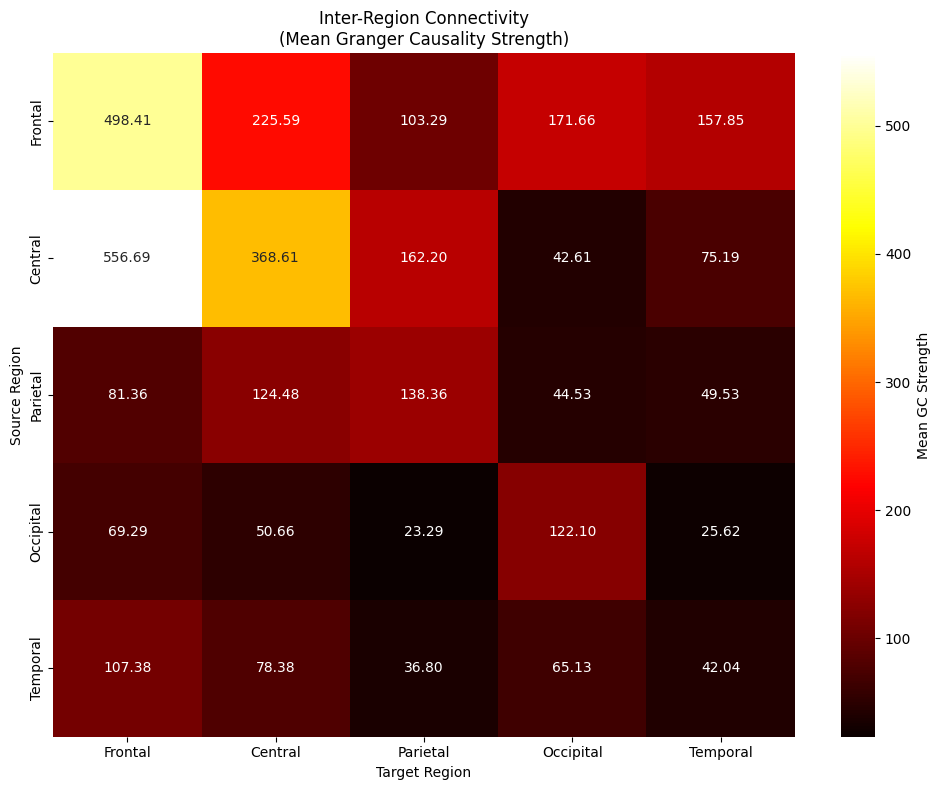


BRAIN REGION CONNECTIVITY SUMMARY
Frontal → Frontal: 498.413
Frontal → Central: 225.588
Frontal → Parietal: 103.294
Frontal → Occipital: 171.662
Frontal → Temporal: 157.853
Central → Frontal: 556.687
Central → Central: 368.612
Central → Parietal: 162.202
Central → Occipital: 42.613
Central → Temporal: 75.187
Parietal → Frontal: 81.357
Parietal → Central: 124.482
Parietal → Parietal: 138.361
Parietal → Occipital: 44.525
Parietal → Temporal: 49.530
Occipital → Frontal: 69.286
Occipital → Central: 50.664
Occipital → Parietal: 23.291
Occipital → Occipital: 122.097
Occipital → Temporal: 25.622
Temporal → Frontal: 107.375
Temporal → Central: 78.384
Temporal → Parietal: 36.801
Temporal → Occipital: 65.131
Temporal → Temporal: 42.036


In [85]:
def calculate_region_connectivity(region_pair_args):
    """Helper for parallel region connectivity calculation"""
    i, j, src_region, tgt_region, channel_names, gc_matrix, p_values, ch_to_region, alpha = region_pair_args
    
    strengths = []
    for src_ch in channel_names:
        for tgt_ch in channel_names:
            if (src_ch in ch_to_region and tgt_ch in ch_to_region and
                ch_to_region[src_ch] == src_region and 
                ch_to_region[tgt_ch] == tgt_region and 
                src_ch != tgt_ch):
                
                src_idx, tgt_idx = channel_names.index(src_ch), channel_names.index(tgt_ch)
                if p_values[src_idx, tgt_idx] < alpha:
                    strengths.append(gc_matrix[src_idx, tgt_idx])
    
    return i, j, np.mean(strengths) if strengths else 0

def analyze_brain_regions(gc_matrix, p_values, channel_names, alpha=0.05, save_path=None):
    """Analyze connectivity patterns by brain regions"""
    
    # Define brain regions
    regions = {
        'Frontal': ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'FZ'],
        'Central': ['C3', 'C4', 'CZ'],
        'Parietal': ['P3', 'P4', 'PZ'],
        'Occipital': ['O1', 'O2'],
        'Temporal': ['T3', 'T4', 'T5', 'T6']
    }
    
    # Create channel to region mapping
    ch_to_region = {ch: region for region, channels in regions.items() 
                    for ch in channels if ch in channel_names}
    
    region_names = list(regions.keys())
    region_matrix = np.zeros((len(region_names), len(region_names)))
    
    # Prepare parallel processing
    region_args = []
    for i, src_region in enumerate(region_names):
        for j, tgt_region in enumerate(region_names):
            region_args.append((i, j, src_region, tgt_region, channel_names, 
                              gc_matrix, p_values, ch_to_region, alpha))
    
    print(f"Calculating region connectivity")
    
    # Process in parallel
    with ProcessPoolExecutor(max_workers=N_CORES) as executor:
        results = list(executor.map(calculate_region_connectivity, region_args))
    
    # Fill matrix
    for i, j, strength in results:
        region_matrix[i, j] = strength
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(region_matrix, 
                xticklabels=region_names, 
                yticklabels=region_names,
                annot=True, fmt='.2f', cmap='hot',
                cbar_kws={'label': 'Mean GC Strength'})
    
    plt.title('Inter-Region Connectivity\n(Mean Granger Causality Strength)')
    plt.xlabel('Target Region')
    plt.ylabel('Source Region')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\nBRAIN REGION CONNECTIVITY SUMMARY")
    for i, src in enumerate(region_names):
        for j, tgt in enumerate(region_names):
            if region_matrix[i, j] > 0:
                print(f"{src} → {tgt}: {region_matrix[i, j]:.3f}")
    
    return region_matrix

# Run analysis
region_matrix = analyze_brain_regions(
    gc_matrix, p_values, channel_names, 
    save_path=os.path.join(output_dir, 'brain_region_connectivity.png')
)

## 5. Interpretation and Saving Results

This analysis provides insights into the causal relationships between different brain regions in infant EEG data:

In [86]:
print("Saving results...")

# Save numpy arrays
for name, data in [('gc_matrix', gc_matrix), ('p_values', p_values), ('significant_gc', significant_gc)]:
    np.save(f"{output_dir}/{name}.npy", data)

# Save text and CSV files  
open(f"{output_dir}/channel_names.txt", 'w').write('\n'.join(channel_names))
if connections_df is not None: connections_df.to_csv(f"{output_dir}/significant_connections.csv", index=False)
if node_stats is not None: node_stats.to_csv(f"{output_dir}/node_statistics.csv", index=False)

print(f"Results saved to: {output_dir}")

Saving results...
Results saved to: ./Dataset/Infants_data_output/sub-NORB00005_ses-1_task-EEG_eeg


## 6. Time Window Comparison Analysis

This section analyzes how Granger causality patterns change across different time windows within the same recording. This can reveal:
- Temporal stability of connectivity patterns
- Dynamic changes in brain network organization
- Developmental fluctuations in neural interactions

In [87]:
def segment_data_into_windows(data, window_length_sec, overlap_ratio=0.5, sampling_freq=100):
    """Segment EEG data into overlapping time windows"""
    
    window_samples = int(window_length_sec * sampling_freq)
    step_samples = int(window_samples * (1 - overlap_ratio))
    
    windows = []
    window_info = []
    
    for start_idx in range(0, data.shape[1] - window_samples + 1, step_samples):
        end_idx = start_idx + window_samples
        
        # Extract window and create info
        windows.append(data[:, start_idx:end_idx])
        window_info.append({
            'window_idx': len(windows) - 1,
            'start_time': start_idx / sampling_freq,
            'end_time': end_idx / sampling_freq,
            'duration': window_length_sec
        })
    
    print(f"Created {len(windows)} windows of {window_length_sec}s each (overlap: {overlap_ratio*100:.0f}%)")
    
    return windows, window_info

# Quick test setup
window_sizes = [2, 4, 6]  
duration = eeg_subset.shape[1] / new_fs
print(f"Available data: {duration:.1f}s | Testing windows: {window_sizes}s")

Available data: 775.0s | Testing windows: [2, 4, 6]s


In [88]:
WINDOW_LENGTH_SEC = 10

def calculate_gc_for_window(args):
    """Helper for parallel window processing"""
    window_idx, window_data, channel_names, max_lag = args
    try:
        gc_matrix, p_values = calculate_granger_causality(
            window_data, channel_names, max_lag=max_lag
        )
        significant_gc = apply_significance_threshold(gc_matrix, p_values)
        return window_idx, gc_matrix, p_values, significant_gc
    except Exception as e:
        n_channels = len(channel_names)
        zero_matrix = np.zeros((n_channels, n_channels))
        one_matrix = np.ones((n_channels, n_channels))
        return window_idx, zero_matrix, one_matrix, zero_matrix

def calculate_gc_across_windows(data, channel_names, window_length_sec=WINDOW_LENGTH_SEC, 
                                overlap_ratio=0.5, sampling_freq=100, max_lag=3):
    """Calculate Granger causality across multiple time windows"""
    
    # Segment data
    windows, window_info = segment_data_into_windows(
        data, window_length_sec, overlap_ratio, sampling_freq
    )
    
    n_channels = len(channel_names)
    gc_results = {
        'gc_matrices': [None] * len(windows),
        'p_value_matrices': [None] * len(windows),
        'significant_matrices': [None] * len(windows),
        'window_info': window_info
    }
    
    print(f"Calculating GC for {len(windows)} windows")
    
    # Prepare parallel processing
    window_args = [(i, window_data, channel_names, max_lag) 
                   for i, window_data in enumerate(windows)]
    
    # Process in parallel
    with ProcessPoolExecutor(max_workers=N_CORES) as executor:
        results = list(executor.map(calculate_gc_for_window, window_args))
    
    # Store results
    for window_idx, gc_matrix, p_values, significant_gc in results:
        gc_results['gc_matrices'][window_idx] = gc_matrix
        gc_results['p_value_matrices'][window_idx] = p_values
        gc_results['significant_matrices'][window_idx] = significant_gc
        
        n_connections = np.sum(significant_gc > 0)
        print(f"Window {window_idx+1}/{len(windows)}: ✓ {n_connections} connections")
    
    return gc_results

# Run analysis with your configured window length
print(f"ANALYZING {WINDOW_LENGTH_SEC}-SECOND WINDOWS")
gc_windows_custom = calculate_gc_across_windows(
    eeg_subset, channel_names, 
    window_length_sec=WINDOW_LENGTH_SEC,
    overlap_ratio=0.3,
    sampling_freq=new_fs,
    max_lag=3
)

ANALYZING 10-SECOND WINDOWS
Created 110 windows of 10s each (overlap: 30%)
Calculating GC for 110 windows
Window 1/110: ✓ 258 connections
Window 2/110: ✓ 251 connections
Window 3/110: ✓ 204 connections
Window 4/110: ✓ 244 connections
Window 5/110: ✓ 282 connections
Window 6/110: ✓ 247 connections
Window 7/110: ✓ 279 connections
Window 8/110: ✓ 243 connections
Window 9/110: ✓ 206 connections
Window 10/110: ✓ 234 connections
Window 11/110: ✓ 240 connections
Window 12/110: ✓ 258 connections
Window 13/110: ✓ 224 connections
Window 14/110: ✓ 261 connections
Window 15/110: ✓ 313 connections
Window 16/110: ✓ 269 connections
Window 17/110: ✓ 309 connections
Window 18/110: ✓ 246 connections
Window 19/110: ✓ 207 connections
Window 20/110: ✓ 253 connections
Window 21/110: ✓ 267 connections
Window 22/110: ✓ 272 connections
Window 23/110: ✓ 253 connections
Window 24/110: ✓ 308 connections
Window 25/110: ✓ 219 connections
Window 26/110: ✓ 265 connections
Window 27/110: ✓ 286 connections
Window 28/11

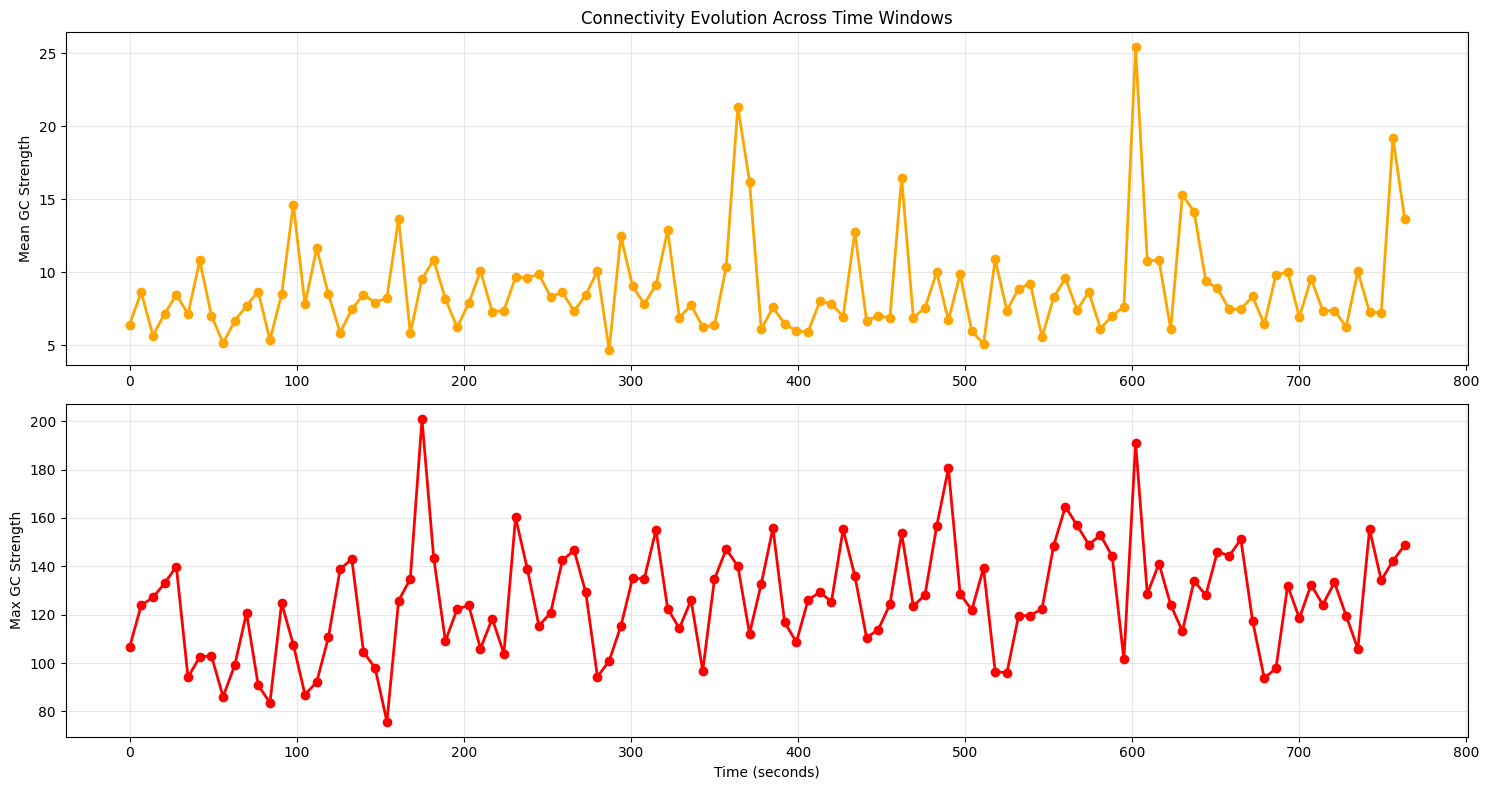

In [89]:
def plot_connectivity_evolution(gc_results, channel_names, save_path=None):
    """Plot how connectivity evolves across time windows"""
    
    gc_matrices = gc_results['gc_matrices']
    window_info = gc_results['window_info']
    
    # Calculate metrics for each window
    metrics = []
    for i, gc_matrix in enumerate(gc_matrices):
        total_conn = np.sum(gc_matrix > 0)
        mean_strength = np.mean(gc_matrix[gc_matrix > 0]) if total_conn > 0 else 0
        
        metrics.append({
            'start_time': window_info[i]['start_time'],
            'total_connections': total_conn,
            'mean_strength': mean_strength,
            'max_strength': np.max(gc_matrix)
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    # Plot mean strength
    ax1.plot(metrics_df['start_time'], metrics_df['mean_strength'], 'o-', color='orange', linewidth=2)
    ax1.set_title('Connectivity Evolution Across Time Windows')
    ax1.set_ylabel('Mean GC Strength')
    ax1.grid(True, alpha=0.3)
    
    # Plot max strength
    ax2.plot(metrics_df['start_time'], metrics_df['max_strength'], 'o-', color='red', linewidth=2)
    ax2.set_ylabel('Max GC Strength')
    ax2.set_xlabel('Time (seconds)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return metrics_df

# Plot connectivity evolution
metrics_df = plot_connectivity_evolution(
    gc_windows_custom, channel_names,
    save_path=os.path.join(output_dir, 'connectivity_evolution.png')
)

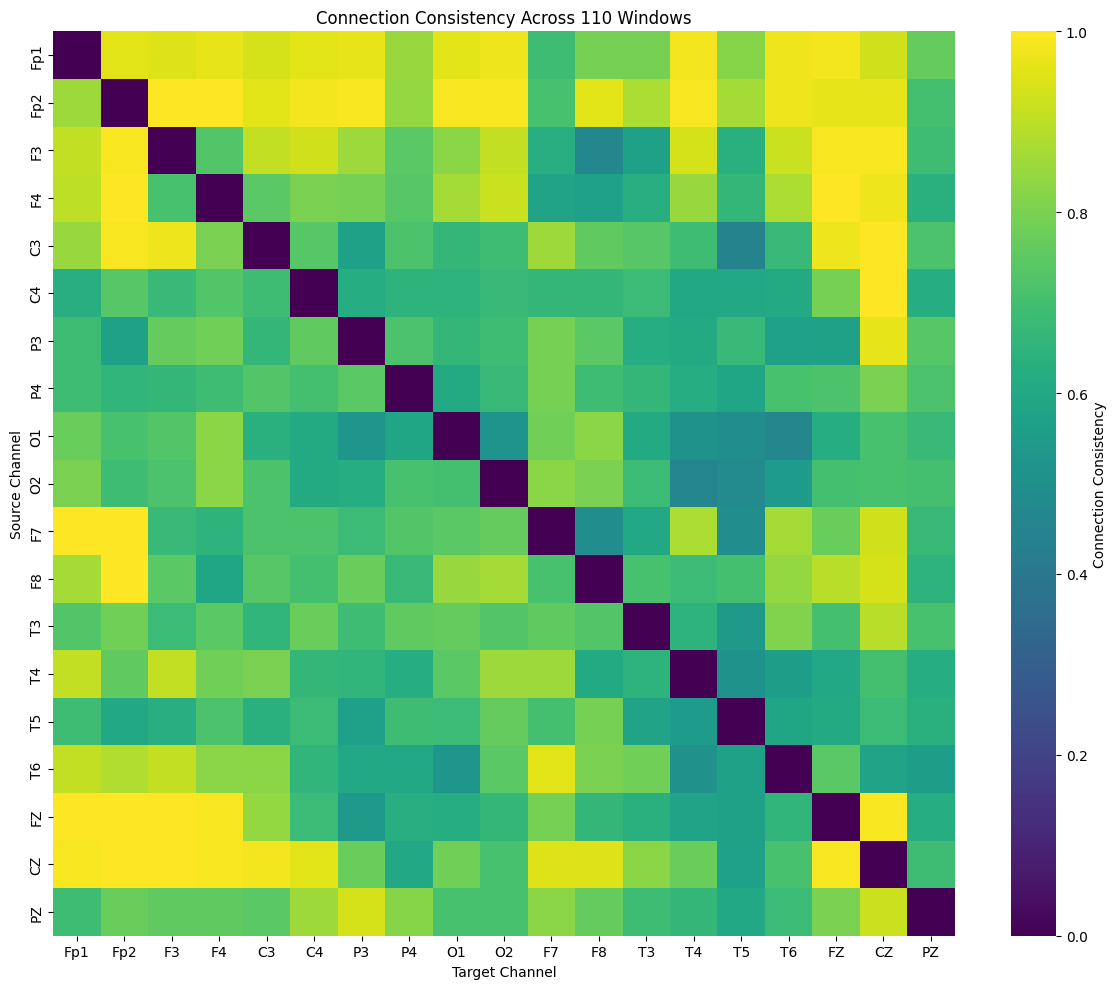


MOST STABLE CONNECTIONS (333 found)
    source target  consistency
299     CZ     F3     1.000000
298     CZ    Fp2     1.000000
280     FZ    Fp2     1.000000
279     FZ    Fp1     1.000000
68      F4     FZ     1.000000
281     FZ     F3     1.000000
86      C3     CZ     1.000000
54      F4    Fp2     1.000000
104     C4     CZ     1.000000
174     F7    Fp1     1.000000
175     F7    Fp2     1.000000
20     Fp2     F4     1.000000
19     Fp2     F3     1.000000
191     F8    Fp2     1.000000
297     CZ    Fp1     0.990909
282     FZ     F4     0.990909
313     CZ     FZ     0.990909
37      F3    Fp2     0.990909
300     CZ     F4     0.990909
50      F3     FZ     0.990909
23     Fp2     P3     0.990909
25     Fp2     O1     0.990909
30     Fp2     T4     0.990909
26     Fp2     O2     0.990909
51      F3     CZ     0.990909
72      C3    Fp2     0.990909
295     FZ     CZ     0.990909
301     CZ     C3     0.981818
22     Fp2     C4     0.981818
12     Fp1     T4     0.981818


In [90]:
def analyze_connectivity_stability(gc_results, channel_names, save_path=None):
    """Analyze stability of connectivity patterns across time windows"""
    
    significant_matrices = gc_results['significant_matrices']
    n_windows = len(significant_matrices)
    n_channels = len(channel_names)
    
    # Calculate connection consistency (vectorized approach)
    consistency = np.zeros((n_channels, n_channels))
    
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j:
                consistency[i, j] = sum(matrix[i, j] > 0 for matrix in significant_matrices) / n_windows
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(consistency, 
                xticklabels=channel_names, 
                yticklabels=channel_names,
                cmap='viridis', 
                vmin=0, vmax=1,
                cbar_kws={'label': 'Connection Consistency'})
    
    plt.title(f'Connection Consistency Across {n_windows} Windows')
    plt.xlabel('Target Channel')
    plt.ylabel('Source Channel')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Find stable connections (>50% consistency)
    stable_list = []
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j and consistency[i, j] > 0.5:
                stable_list.append({
                    'source': channel_names[i],
                    'target': channel_names[j],
                    'consistency': consistency[i, j]
                })
    
    if stable_list:
        stable_df = pd.DataFrame(stable_list).sort_values('consistency', ascending=False)
        print(f"\nMOST STABLE CONNECTIONS ({len(stable_list)} found)")
        print(stable_df.head(30))
        return consistency, stable_df
    else:
        print("\nNo highly stable connections found (>50% consistency)")
        return consistency, None

# Usage
consistency_matrix, stable_connections = analyze_connectivity_stability(
    gc_windows_custom, channel_names,
    save_path=os.path.join(output_dir, 'connectivity_stability.png')
)

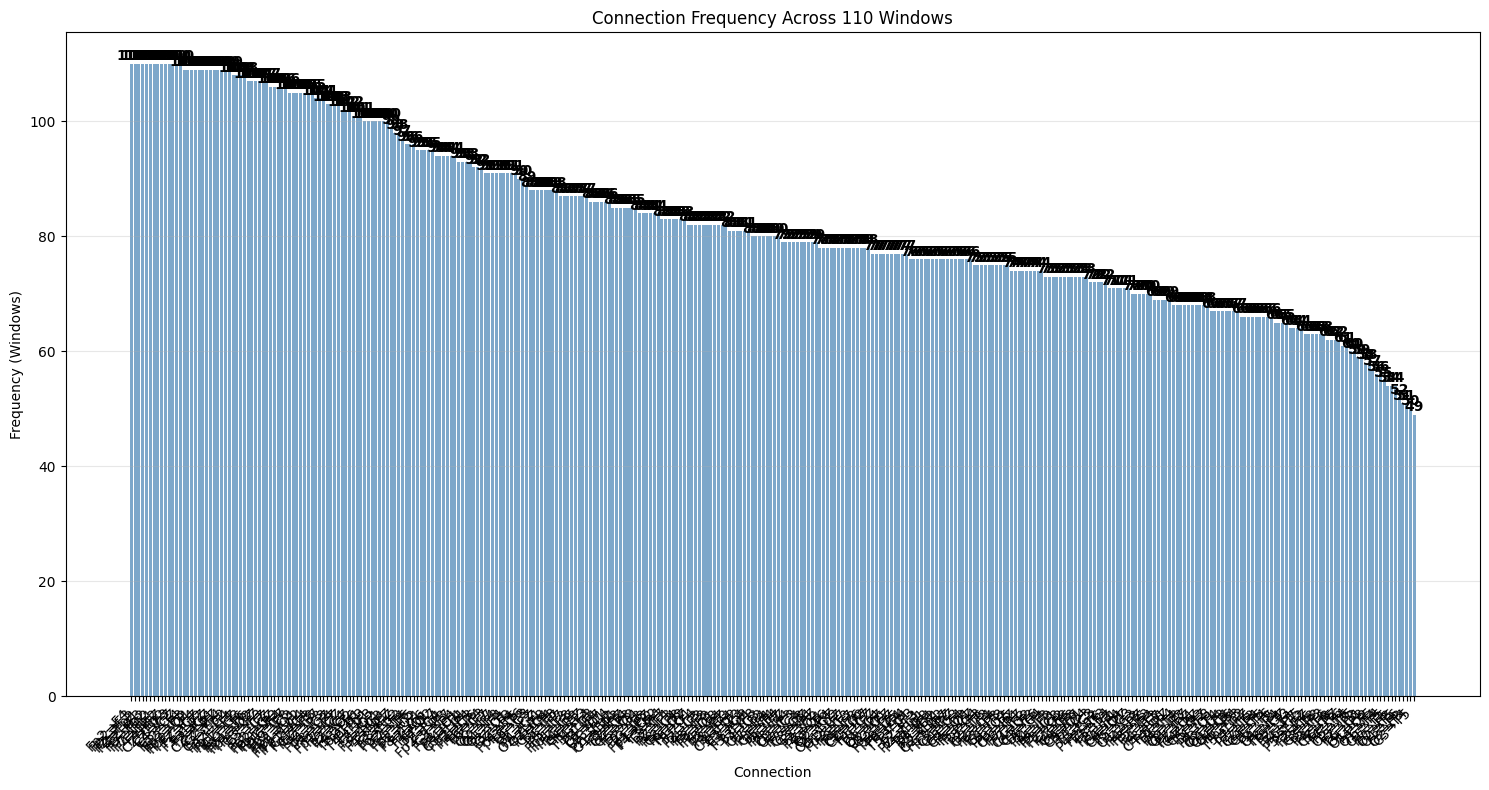


TOP 10 CONNECTIONS
 1. Fp2→F4: 110/110 (100.0%)
 2. Fp2→F3: 110/110 (100.0%)
 3. FZ→Fp2: 110/110 (100.0%)
 4. FZ→Fp1: 110/110 (100.0%)
 5. FZ→F3: 110/110 (100.0%)
 6. F8→Fp2: 110/110 (100.0%)
 7. F7→Fp2: 110/110 (100.0%)
 8. F7→Fp1: 110/110 (100.0%)
 9. F4→Fp2: 110/110 (100.0%)
10. F4→FZ: 110/110 (100.0%)


In [91]:
def plot_connection_frequency(gc_results, channel_names, min_frequency=1, save_path=None):
    """Plot frequency of connections across time windows"""
    
    matrices = gc_results['significant_matrices']
    n_windows = len(matrices)
    n_channels = len(channel_names)
    
    # Count connection frequencies
    frequencies = []
    names = []
    
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j:
                count = sum(matrix[i, j] > 0 for matrix in matrices)
                if count >= min_frequency:
                    frequencies.append(count)
                    names.append(f"{channel_names[i]}→{channel_names[j]}")
    
    if not frequencies:
        print(f"No connections found with frequency ≥ {min_frequency}")
        return None
    
    # Sort by frequency
    sorted_data = sorted(zip(frequencies, names), reverse=True)
    frequencies, names = zip(*sorted_data)
    
    # Plot
    plt.figure(figsize=(15, 8))
    bars = plt.bar(range(len(frequencies)), frequencies, color='steelblue', alpha=0.7)
    
    plt.xlabel('Connection')
    plt.ylabel('Frequency (Windows)')
    plt.title(f'Connection Frequency Across {n_windows} Windows')
    plt.xticks(range(len(names)), names, rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    
    # Add value labels
    for bar, freq in zip(bars, frequencies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(freq), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print top connections
    print(f"\nTOP 10 CONNECTIONS")
    for i, (freq, name) in enumerate(zip(frequencies[:10], names[:10])):
        print(f"{i+1:2d}. {name}: {freq}/{n_windows} ({freq/n_windows*100:.1f}%)")
    
    return frequencies, names

# Usage - Fixed variable name
result = plot_connection_frequency(
    gc_windows_custom, channel_names,
    min_frequency=1,
    save_path=os.path.join(output_dir, 'connection_frequency.png')
)

In [92]:
def process_window_size(args):
    """Helper for parallel window size processing"""
    size, data, channel_names, sampling_freq = args
    print(f"Analyzing {size}s windows...")
    return size, calculate_gc_across_windows(
        data, channel_names,
        window_length_sec=size,
        overlap_ratio=0.3,
        sampling_freq=sampling_freq,
        max_lag=3
    )

def compare_window_sizes(data, channel_names, window_sizes, sampling_freq):
    """Compare connectivity patterns across different window sizes"""
    
    # Prepare parallel processing
    size_args = [(size, data, channel_names, sampling_freq) for size in window_sizes]
    
    print(f"Comparing {len(window_sizes)} window sizes")
    
    # Process in parallel
    with ProcessPoolExecutor(max_workers=min(len(window_sizes), N_CORES)) as executor:
        results = list(executor.map(process_window_size, size_args))
    
    return dict(results)

# Smart window size selection
duration = eeg_subset.shape[1] / new_fs
print(f"Available data: {duration:.1f}s")

window_sizes = [WINDOW_LENGTH_SEC - 4, WINDOW_LENGTH_SEC, WINDOW_LENGTH_SEC + 4]  # seconds

print(f"Testing windows: {window_sizes}s")

# Run comparison if we have enough data
if duration > min(window_sizes) * 3:
    window_comparison = compare_window_sizes(eeg_subset, channel_names, window_sizes, new_fs)
else:
    print("Insufficient data for comparison")
    window_comparison = None

Available data: 775.0s
Testing windows: [6, 10, 14]s
Comparing 3 window sizes
Analyzing 6s windows...
Created 184 windows of 6s each (overlap: 30%)
Calculating GC for 184 windows
Analyzing 6s windows...
Created 184 windows of 6s each (overlap: 30%)
Calculating GC for 184 windows
Analyzing 10s windows...
Created 110 windows of 10s each (overlap: 30%)
Calculating GC for 110 windows
Analyzing 10s windows...
Created 110 windows of 10s each (overlap: 30%)
Calculating GC for 110 windows
Analyzing 14s windows...
Created 78 windows of 14s each (overlap: 30%)
Calculating GC for 78 windows
Analyzing 14s windows...
Created 78 windows of 14s each (overlap: 30%)
Calculating GC for 78 windows
Window 1/78: ✓ 282 connections
Window 2/78: ✓ 235 connectionsWindow 3/78: ✓ 293 connections

Window 4/78: ✓ 305 connections
Window 1/78: ✓ 282 connections
Window 2/78: ✓ 235 connectionsWindow 3/78: ✓ 293 connections

Window 4/78: ✓ 305 connections
Window 5/78: ✓ 297 connections
Window 5/78: ✓ 297 connections
Wi

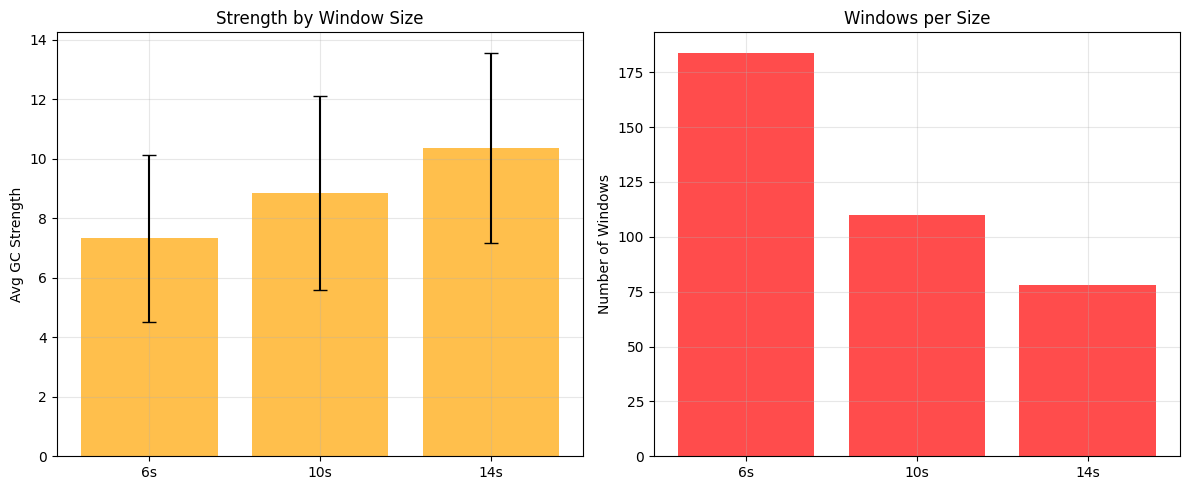


WINDOW SIZE COMPARISON
6s: 184 windows, avg strength: 7.324±2.808
10s: 110 windows, avg strength: 8.843±3.257
14s: 78 windows, avg strength: 10.377±3.197


In [93]:
def plot_window_size_comparison(window_comparison, channel_names, save_path=None):
    """Plot comparison of connectivity metrics across different window sizes"""
    if window_comparison is None:
        print("No window comparison data available")
        return
    
    window_sizes = list(window_comparison.keys())
    
    # Collect metrics for each window size
    stats = {}
    for size in window_sizes:
        matrices = window_comparison[size]['gc_matrices']
        connections = [np.sum(matrix > 0) for matrix in matrices]
        strengths = [np.mean(matrix[matrix > 0]) if np.sum(matrix > 0) > 0 else 0 
                    for matrix in matrices]
        
        stats[size] = {
            'avg_strength': np.mean(strengths),
            'std_strength': np.std(strengths),
            'num_windows': len(matrices)
        }
    
    # Create 1x2 subplot (only 2 plots now)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    colors = ['orange', 'red']
    
    # Plot 1: Average strength
    sizes_labels = [f'{size}s' for size in window_sizes]
    avg_str = [stats[size]['avg_strength'] for size in window_sizes]
    std_str = [stats[size]['std_strength'] for size in window_sizes]
    
    axes[0].bar(sizes_labels, avg_str, yerr=std_str, capsize=5, 
                alpha=0.7, color=colors[0])
    axes[0].set_ylabel('Avg GC Strength')
    axes[0].set_title('Strength by Window Size')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Number of windows
    n_windows = [stats[size]['num_windows'] for size in window_sizes]
    
    axes[1].bar(sizes_labels, n_windows, alpha=0.7, color=colors[1])
    axes[1].set_ylabel('Number of Windows')
    axes[1].set_title('Windows per Size')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\nWINDOW SIZE COMPARISON")
    for size in window_sizes:
        s = stats[size]
        print(f"{size}s: {s['num_windows']} windows, "
              f"avg strength: {s['avg_strength']:.3f}±{s['std_strength']:.3f}")

# Usage
if window_comparison:
    plot_window_size_comparison(
        window_comparison, channel_names,
        save_path=os.path.join(output_dir, 'window_size_comparison.png')
    )


=== TEMPORAL DYNAMICS ===


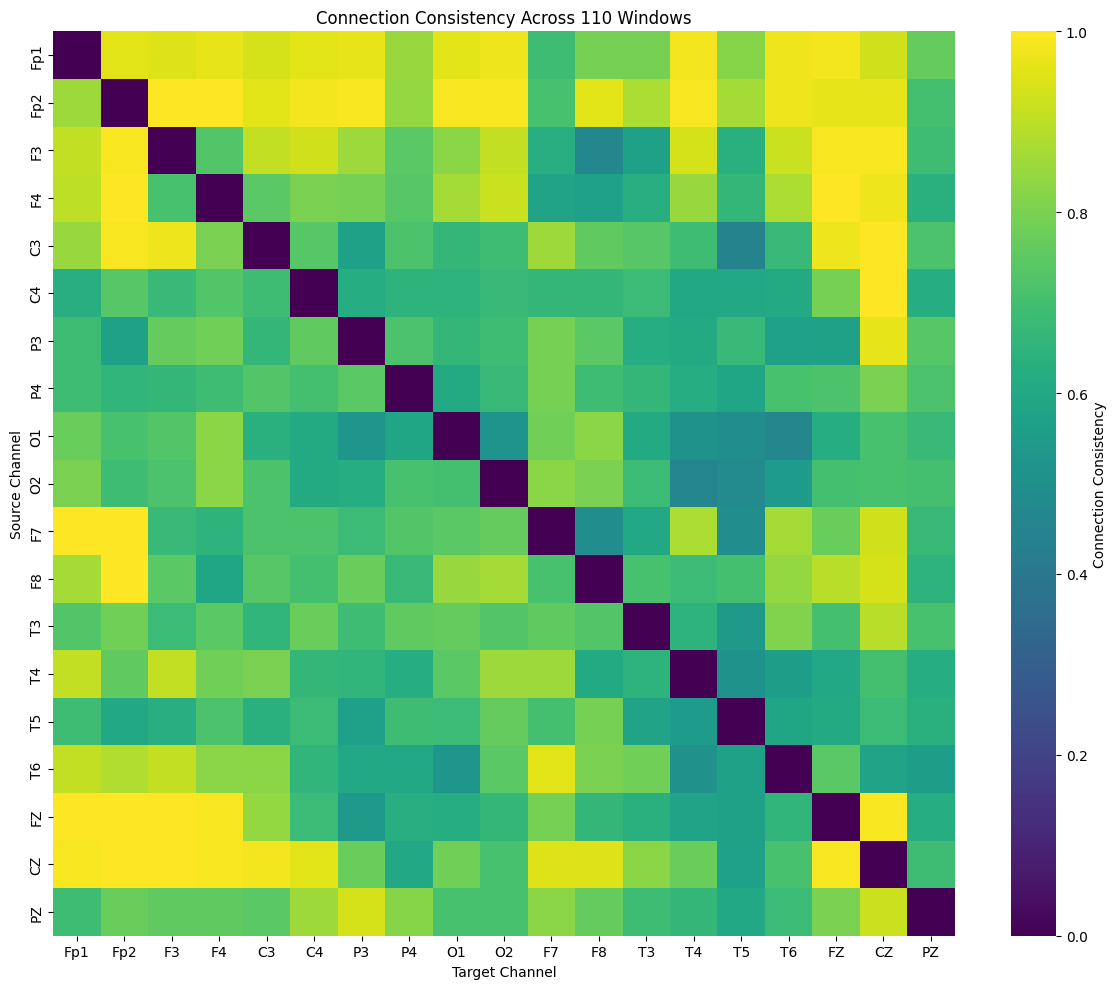


MOST STABLE CONNECTIONS (333 found)
    source target  consistency
299     CZ     F3     1.000000
298     CZ    Fp2     1.000000
280     FZ    Fp2     1.000000
279     FZ    Fp1     1.000000
68      F4     FZ     1.000000
281     FZ     F3     1.000000
86      C3     CZ     1.000000
54      F4    Fp2     1.000000
104     C4     CZ     1.000000
174     F7    Fp1     1.000000
175     F7    Fp2     1.000000
20     Fp2     F4     1.000000
19     Fp2     F3     1.000000
191     F8    Fp2     1.000000
297     CZ    Fp1     0.990909
282     FZ     F4     0.990909
313     CZ     FZ     0.990909
37      F3    Fp2     0.990909
300     CZ     F4     0.990909
50      F3     FZ     0.990909
23     Fp2     P3     0.990909
25     Fp2     O1     0.990909
30     Fp2     T4     0.990909
26     Fp2     O2     0.990909
51      F3     CZ     0.990909
72      C3    Fp2     0.990909
295     FZ     CZ     0.990909
301     CZ     C3     0.981818
22     Fp2     C4     0.981818
12     Fp1     T4     0.981818


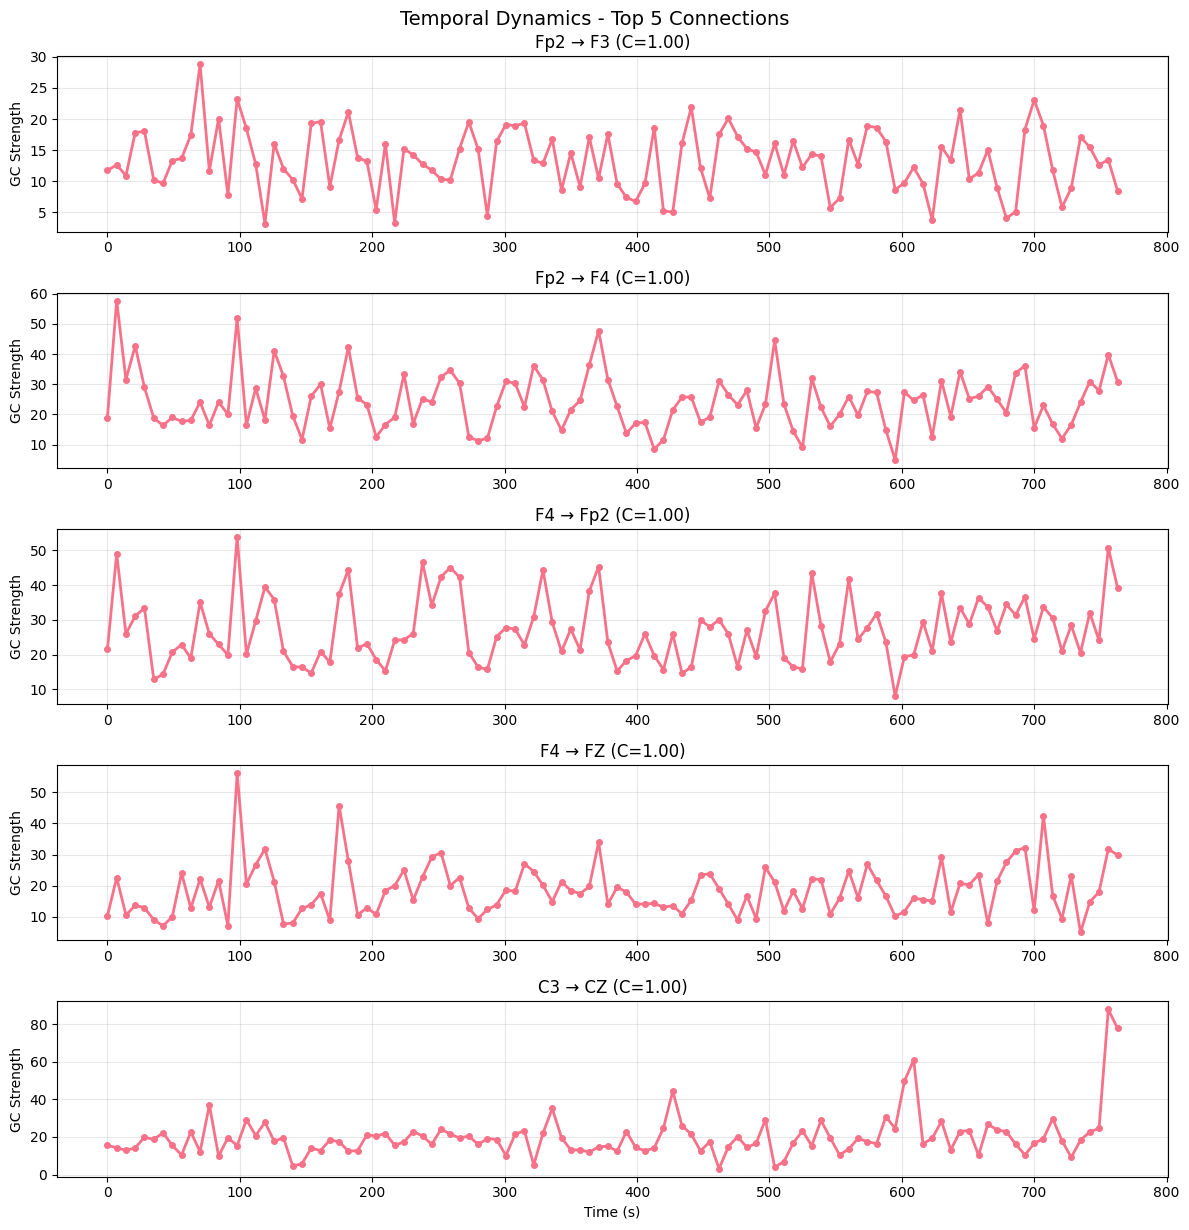

Analyzed 5 strongest connections:
  Fp2 → F3: 1.000
  Fp2 → F4: 1.000
  F4 → Fp2: 1.000
  F4 → FZ: 1.000
  C3 → CZ: 1.000


In [94]:
def analyze_temporal_dynamics(gc_results, channel_names, max_pairs=5, save_path=None):
    """Analyze temporal evolution of strongest connections"""
    
    # Get data
    gc_matrices = gc_results['gc_matrices']
    window_info = gc_results['window_info']
    
    # Find most consistent connections
    consistency_matrix, _ = analyze_connectivity_stability(gc_results, channel_names)
    
    # Get top connections (simplified selection)
    top_pairs = []
    for i in range(len(channel_names)):
        for j in range(len(channel_names)):
            if i != j and consistency_matrix[i, j] > 0.2:  # Lower threshold
                top_pairs.append((i, j, consistency_matrix[i, j]))
    
    # Sort and limit
    top_pairs = sorted(top_pairs, key=lambda x: x[2], reverse=True)[:max_pairs]
    
    if not top_pairs:
        print("No stable connections found")
        return None
    
    # Plot evolution
    n_pairs = len(top_pairs)
    fig, axes = plt.subplots(n_pairs, 1, figsize=(12, 2.5*n_pairs))
    if n_pairs == 1: axes = [axes]
    
    for idx, (i, j, consistency) in enumerate(top_pairs):
        # Extract time series
        gc_values = [matrix[i, j] for matrix in gc_matrices]
        time_points = [info['start_time'] for info in window_info]
        
        # Plot
        axes[idx].plot(time_points, gc_values, 'o-', linewidth=2, markersize=4)
        axes[idx].set_title(f'{channel_names[i]} → {channel_names[j]} (C={consistency:.2f})')
        axes[idx].set_ylabel('GC Strength')
        axes[idx].grid(True, alpha=0.3)
        
        # X-label only on last plot
        if idx == n_pairs - 1:
            axes[idx].set_xlabel('Time (s)')
    
    plt.suptitle(f'Temporal Dynamics - Top {n_pairs} Connections', fontsize=14)
    plt.tight_layout()
    
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary
    print(f"Analyzed {n_pairs} strongest connections:")
    for i, j, c in top_pairs:
        print(f"  {channel_names[i]} → {channel_names[j]}: {c:.3f}")
    
    return top_pairs

# Usage (simplified)
if 'gc_windows_custom' in locals():
    print("\n=== TEMPORAL DYNAMICS ===")
    temporal_pairs = analyze_temporal_dynamics(
        gc_windows_custom, channel_names,
        save_path=os.path.join(output_dir, 'temporal_dynamics.png')
    )

In [96]:
# Save time window analysis results
print("\n=== SAVING RESULTS ===")

def save_results():
    """Save all analysis results and plots"""
    saved_files = []
    
    try:
        # Save main GC results
        for name, data in [('gc_matrix', gc_matrix), ('p_values', p_values), ('significant_gc', significant_gc)]:
            if name in globals():
                np.save(os.path.join(output_dir, f'{name}.npy'), data)
                saved_files.append(f'{name}.npy')
        
        # Save window analysis if available
        if 'gc_windows_custom' in locals():
            np.save(os.path.join(output_dir, 'window_matrices.npy'), gc_windows_custom['gc_matrices'])
            np.save(os.path.join(output_dir, 'window_pvalues.npy'), gc_windows_custom['p_value_matrices'])
            saved_files.extend(['window_matrices.npy', 'window_pvalues.npy'])
        
        # Save CSV files
        if 'connections_df' in locals() and connections_df is not None:
            connections_df.to_csv(os.path.join(output_dir, 'connections.csv'), index=False)
            saved_files.append('connections.csv')
            
        if 'node_stats' in locals():
            node_stats.to_csv(os.path.join(output_dir, 'node_stats.csv'), index=False)
            saved_files.append('node_stats.csv')
        
        # Save channel names
        with open(os.path.join(output_dir, 'channels.txt'), 'w') as f:
            f.write('\n'.join(channel_names))
        saved_files.append('channels.txt')
        
        print(f"Saved {len(saved_files)} files to: {output_dir}")
        
    except Exception as e:
        print(f"Error saving: {e}")

# Save everything
save_results()
print("\nANALYSIS COMPLETE!")


=== SAVING RESULTS ===
Saved 4 files to: ./Dataset/Infants_data_output/sub-NORB00005_ses-1_task-EEG_eeg

ANALYSIS COMPLETE!


## 7. Time Window Analysis Summary

The time window analysis provides insights into:

### Temporal Stability
- **Connection Consistency**: How often specific connections appear across different time windows
- **Strength Variability**: How much connection strengths fluctuate over time
- **Network Dynamics**: Changes in overall connectivity patterns

### Window Size Effects
- **Optimal Window Length**: Balance between temporal resolution and statistical power
- **Detection Sensitivity**: Shorter windows may miss transient connections, longer windows may average out dynamics
- **Computational Efficiency**: Trade-off between detail and processing time

### Developmental Insights
- **Maturation Patterns**: Stable vs. variable connections may reflect different developmental stages
- **Functional Networks**: Consistent connections likely represent established neural pathways
- **Plasticity Indicators**: Variable connections may indicate ongoing neural plasticity

### Methodological Considerations
- **Statistical Power**: Longer windows provide more data points for robust GC estimation
- **Temporal Resolution**: Shorter windows better capture rapid neural dynamics
- **Overlap Strategy**: Window overlap affects independence of observations but improves temporal resolution